Importing the libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import time
import random

In [42]:
workbook = xlrd.open_workbook('ToyotaCorolla.xls')
number = workbook.nsheets
worksheet = workbook.sheet_by_index(1)
print(worksheet)

Reading the data base into a pandas data frame:

In [43]:
toyota_data = pd.read_excel('ToyotaCorolla.xls', sheet_name=1)
toyota_data.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,CC,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,Blue,0,2000,3,4,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,Silver,0,2000,3,4,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,Blue,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,Black,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,Black,0,2000,3,4,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0


In [44]:
toyota_data.isnull().sum()

Id                   0
Model                0
Price                0
Age_08_04            0
Mfg_Month            0
Mfg_Year             0
KM                   0
Fuel_Type            0
HP                   0
Met_Color            0
Color                0
Automatic            0
CC                   0
Doors                0
Cylinders            0
Gears                0
Quarterly_Tax        0
Weight               0
Mfr_Guarantee        0
BOVAG_Guarantee      0
Guarantee_Period     0
ABS                  0
Airbag_1             0
Airbag_2             0
Airco                0
Automatic_airco      0
Boardcomputer        0
CD_Player            0
Central_Lock         0
Powered_Windows      0
Power_Steering       0
Radio                0
Mistlamps            0
Sport_Model          0
Backseat_Divider     0
Metallic_Rim         0
Radio_cassette       0
Parking_Assistant    0
Tow_Bar              0
dtype: int64

from above we could see that there is no null value for any feature, hence there is no need to eliminate anything

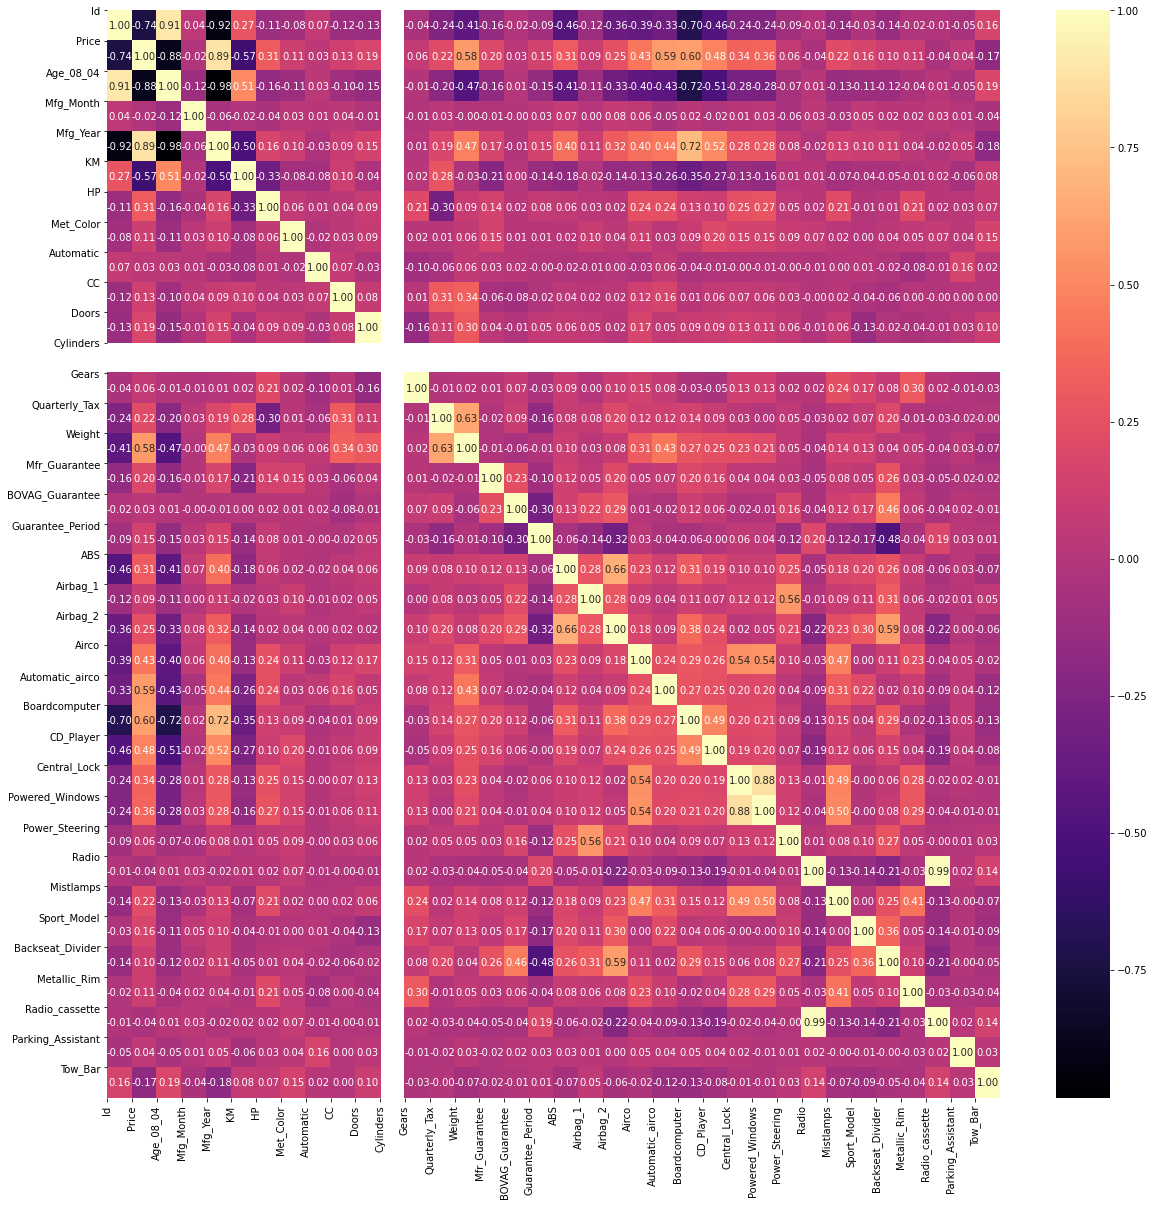

In [45]:
corr = toyota_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")

plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

همان‌طور که مشخص است و انتظار هم داشتیم ردیف قیمت با کیلومتر طی شده توسط ماشین ها رابطه‌ی کوریلیشن منفی قوی دارد، به این معنا که هر چقدر کیلومتر طی شده توسط ماشینی بیشتر بوده ، قیمت آن هم کمتر شده است


---





In [46]:
toyota_data.drop('Id', inplace=True, axis=1)
toyota_data.drop('Model', inplace=True, axis=1)
toyota_data.drop('Cylinders', inplace=True, axis=1)
toyota_data.drop(['Radio_cassette', 'Powered_Windows'], axis=1, inplace=True)
toyota_data = pd.get_dummies(toyota_data['Fuel_Type'], prefix='Fuel').join(toyota_data)
toyota_data = pd.get_dummies(toyota_data['Color'], prefix='Color').join(toyota_data)
toyota_data.drop(['Fuel_Type', 'Color'], axis=1, inplace=True)
toyota_data.head()

,Color_Beige,Color_Black,Color_Blue,Color_Green,Color_Grey,Color_Red,Color_Silver,Color_Violet,Color_White,Color_Yellow,Fuel_CNG,Fuel_Diesel,Fuel_Petrol,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,CC,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
0,0,0,1,0,0,0,0,0,0,0,0,1,0,13500,23,10,2002,46986,90,1,0,2000,3,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,13750,23,10,2002,72937,90,1,0,2000,3,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,13950,24,9,2002,41711,90,1,0,2000,3,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,14950,26,7,2002,48000,90,0,0,2000,3,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,13750,30,3,2002,38500,90,0,0,2000,3,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0


برای این که مقادیری که مقدار عددی ندارن را بتوانیم استفاده کنیم( مانند رنگ )باید مپ عددی بکنیم

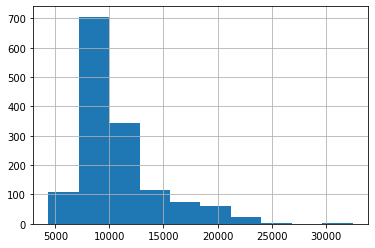

In [47]:
toyota_data['Price'].hist()

In [48]:
toyota_data.head()

,Color_Beige,Color_Black,Color_Blue,Color_Green,Color_Grey,Color_Red,Color_Silver,Color_Violet,Color_White,Color_Yellow,Fuel_CNG,Fuel_Diesel,Fuel_Petrol,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,CC,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
0,0,0,1,0,0,0,0,0,0,0,0,1,0,13500,23,10,2002,46986,90,1,0,2000,3,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,13750,23,10,2002,72937,90,1,0,2000,3,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,13950,24,9,2002,41711,90,1,0,2000,3,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,14950,26,7,2002,48000,90,0,0,2000,3,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,13750,30,3,2002,38500,90,0,0,2000,3,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0


In [49]:
train_and_valid = toyota_data.sample(frac=0.85, random_state=int(time.time()), replace=False)
test = toyota_data.drop(train_and_valid.index)
train = train_and_valid.sample(frac=0.824, random_state=int(time.time()), replace=False)
valid = train_and_valid.drop(train.index)

print(train.shape, test.shape, valid.shape)
test.to_csv(r'test.csv', index=False, header=True)

(1006, 45) (215, 45) (215, 45)


In [50]:

#the color beige and tow bar need biases to be added to them 
x_train = train.loc[:, 'Color_Beige':'Tow_Bar'].copy().to_numpy()
y_train = train['Price'].to_numpy()
x_valid = valid.loc[:, 'Color_Beige':'Tow_Bar'].copy().to_numpy()
y_valid = valid['Price'].to_numpy()
x_test = test.loc[:, 'Color_Beige':'Tow_Bar'].copy().to_numpy()
y_test = test['Price'].to_numpy()

bias_train = np.ones((x_train.shape[0], 1))
bias_test= np.ones((x_test.shape[0], 1))
bias_valid = np.ones((x_valid.shape[0], 1))

x_train = np.hstack((x_train, bias_train))
x_test = np.hstack((x_test, bias_test))
x_valid = np.hstack((x_valid, bias_valid))

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(1006, 46) (1006,)
(215, 46) (215,)
(215, 46) (215,)


In [77]:
def CustomSGD(x,learning_rate,n_iter,k,divideby):
    
    w=np.zeros(shape=(1,x.shape[1]-1))
    b=0
    cur_iter=1
    while(cur_iter<=n_iter): 
        temp=x.sample(k)
        y=np.array(temp['Price'])
        x=np.array(temp.drop('Price',axis=1))
        w_gradient=np.zeros(shape=(1,x.shape[1]-1))
        b_gradient=0
        for i in range(k): 
            prediction=np.dot(w,x[i])+b
            w_gradient=w_gradient+(-2)*x[i]*(y[i]-(prediction))
            b_gradient=b_gradient+(-2)*(y[i]-(prediction))
        w=w-learning_rate*(w_gradient/k)
        b=b-learning_rate*(b_gradient/k)
        cur_iter=cur_iter+1
        learning_rate=learning_rate/divideby
    return w,b #Returning the weights and Bias


def sgd_mae(x, y, alpha, iteration):
    global x_valid, y_valid, x_test, y_test
    w = np.ones(46)
    mae_valid, mae_test = [], []

    for itr in range(iteration):
        for i in range(len(x)):
            row = random.randint(0, len(x) - 1)
            #a random row index is chosen to make the random part 
            t = np.absolute(np.dot(x[row], w) - y[row])
            w = w - 2 * x[row] * (np.dot(x[row], w) - y[row]) * alpha / t
        er = mse(x_valid, w, y_valid)
        mae_valid.append(er)
        er_test = mse(x_test, w, y_test)
        mae_test.append(er_test)

    return w, mae_valid, mae_test


def sgd (x, y, iteration ,alpha):
    global  x_test, y_test, x_valid, y_valid
    w = np.ones(46) 
    mse_valid, mse_test = [], []
    for itr in range(iteration):
        length = len(x)
        for i in range(length):
            idx = random.randint(0, length- 1)
            w = w - 2 * (np.dot(x[idx], w) - y[idx]) * alpha * x[idx]
        mse_valid.append(mse(x_valid, w, y_valid))
        mse_test.append(mse(x_test, w, y_test))
    return w, mse_valid, mse_test    

def mae(x, weights, y):
    predict = x.dot(weights)
    mae_error = np.sum(np.absolute(predict - y)) / len(y)
    return mae_error

def mse(x, weights, y):
    yi = np.dot(x, weights)
    mse_error = 0.5 * np.sum(np.square(yi - y)) / len(y)
    return mse_error



alpha is :  10 to the power of (-10)


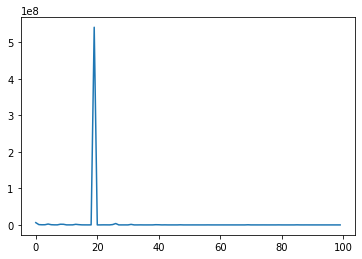

alpha is :  10 to the power of (-11)


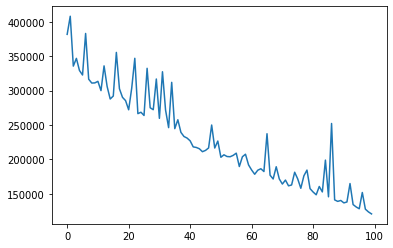

alpha is :  10 to the power of (-12)


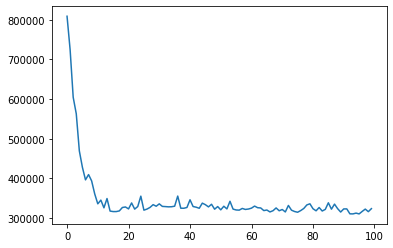

alpha is :  10 to the power of (-13)


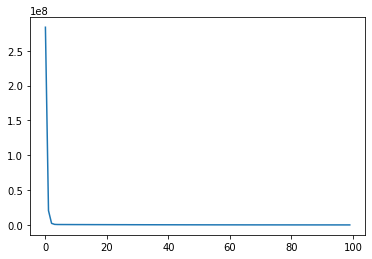

alpha is :  10 to the power of (-14)


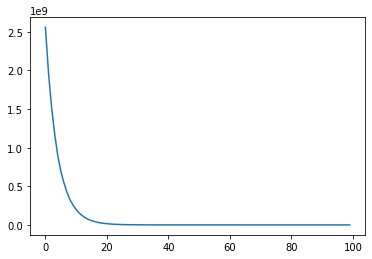

alpha is :  10 to the power of (-15)


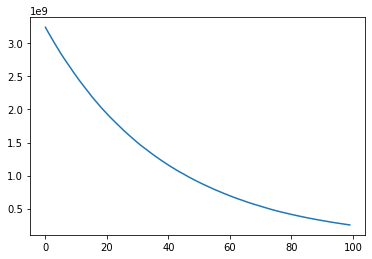

alpha is :  10 to the power of (-16)


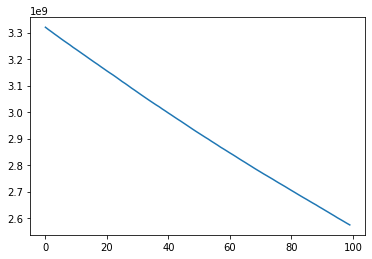

In [61]:
for i in range(10, 17):
    w, mse_valid, mse_test = sgd(x_train, y_train, 100,  10 ** (-i))
    print('alpha is :  10 to the power of (-{})'.format(i))
    plt.plot(np.arange(len(mse_valid)), mse_valid)
    plt.show()


alpha is :  10 to the power of (-10)


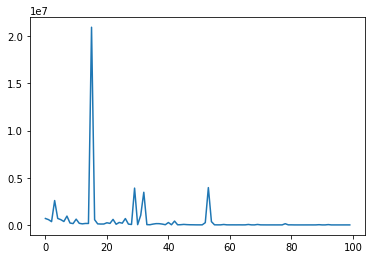

alpha is :  10 to the power of (-11)


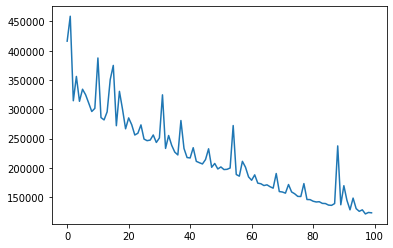

alpha is :  10 to the power of (-12)


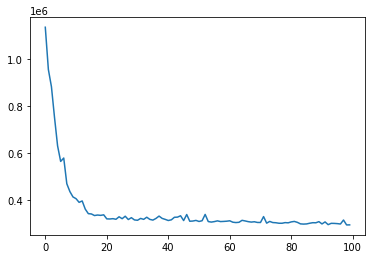

alpha is :  10 to the power of (-13)


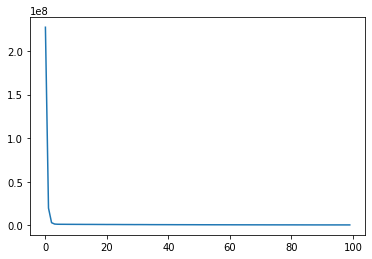

alpha is :  10 to the power of (-14)


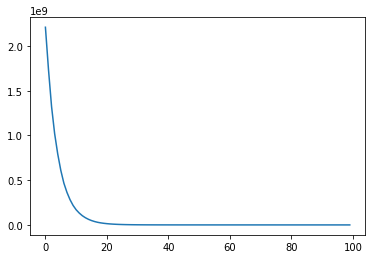

alpha is :  10 to the power of (-15)


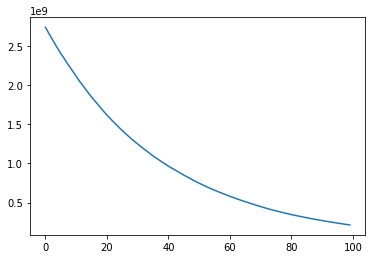

alpha is :  10 to the power of (-16)


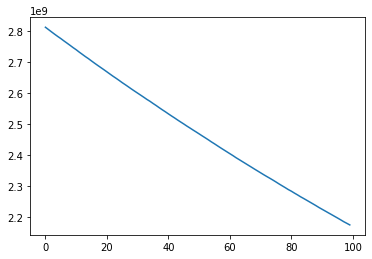

In [62]:
for i in range(10, 17):
    w, mse_valid, mse_test = sgd(x_train, y_train, 100,  10 ** (-i))
    print('alpha is :  10 to the power of (-{})'.format(i))
    plt.plot(np.arange(len(mse_test)), mse_test)
    plt.show()

the alpha is:  10 to the power of (-7)


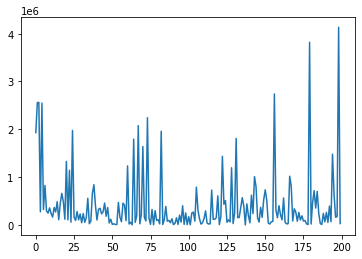

the alpha is:  10 to the power of (-8)


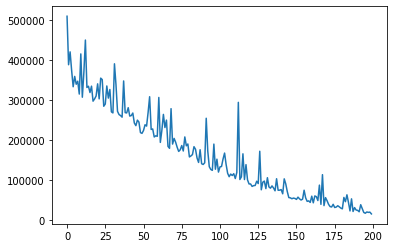

the alpha is:  10 to the power of (-9)


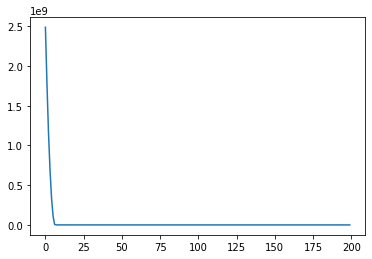

the alpha is:  10 to the power of (-10)


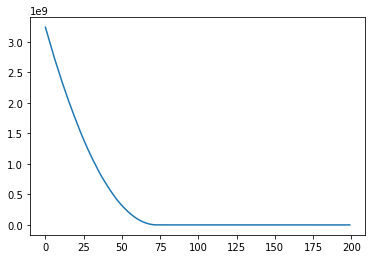

the alpha is:  10 to the power of (-11)


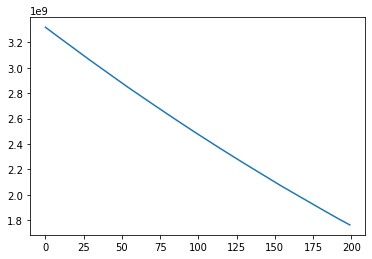

In [65]:
for i in range(7, 12):
    w, mae_valid, mae_test = sgd_mae(x_train, y_train, 10 ** (-i), 200)
    print('the alpha is:  10 to the power of (-{})'.format(i))
    plt.plot(np.arange(len(mae_valid)), mae_valid)
    plt.show()

the alpha is:  10 to the power of (-7)


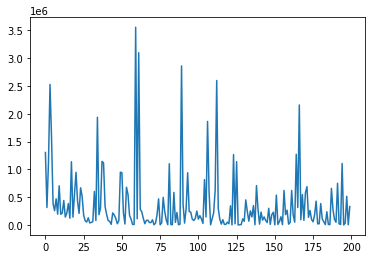

the alpha is:  10 to the power of (-8)


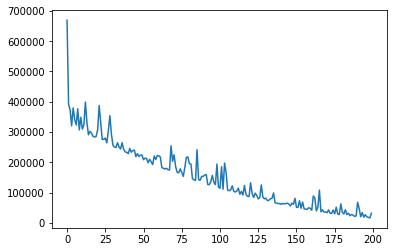

the alpha is:  10 to the power of (-9)


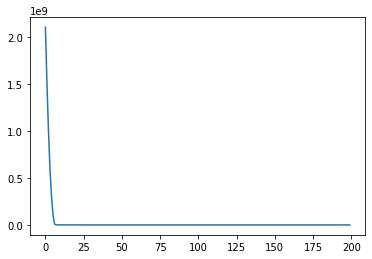

the alpha is:  10 to the power of (-10)


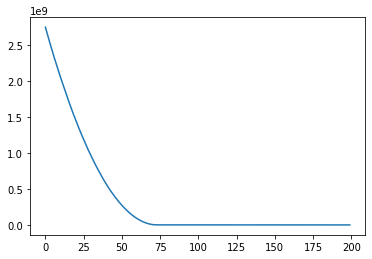

the alpha is:  10 to the power of (-11)


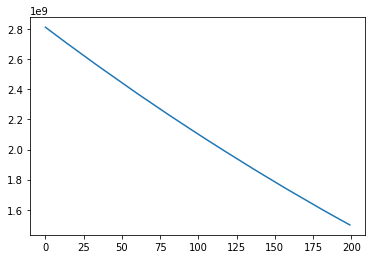

In [66]:
for i in range(6, 11):
    w, mae_valid, mae_test = sgd_mae(x_train, y_train, 10 ** (-i), 200)
    print('the alpha is:  10 to the power of (-{})'.format(i))
    plt.plot(np.arange(len(mae_test)), mae_test)
    plt.show()

In [76]:
def ridge(x, y, landa):
  inv_dot = np.linalg.inv(np.add(np.dot(x.T, x), landa * np.identity(46)))
  return np.dot(np.linalg.inv(np.add(np.dot(x.T, x), landa * np.identity(46))), np.dot(x.T, y))

weight = ridge(x_train, y_train, 1)

print(mse(x_train, weight, y_train))
print(mse(x_valid, weight, y_valid))
print(mse(x_test, weight, y_test))

5.736570682498527e-13
8.190823025311606e-13
4.869289760595277e-13
